In [38]:
renv::activate()

In [35]:
library(dplyr)
library(ggplot2)
library(reshape2)

options(warn=-1, repr.plot.width=16, repr.plot.height=12)
suppressMessages(warning('testit'))


Attaching package: ‘tidyr’


The following object is masked from ‘package:reshape2’:

    smiths




## Subset Data to only the % of Immune cells

In [3]:
## child data
child <- read.table('data/child_forest_imputed.tsv',
                    sep = '\t', header = TRUE, stringsAsFactors=FALSE)
child.p <- dplyr::select(child,
                         Percent.CD4.T.cells:Percent.DRpositive.CD38negative.of.CD8.Tem.cells
)

## Adult data
adult <- read.table('data/adult_forest_imputed.tsv',
                    sep = '\t', header = TRUE, stringsAsFactors=FALSE)
adult.p <- dplyr::select(adult,
                         Percent.CD4.T.cells:Percent.DRpositive.CD38negative.of.CD8.Tem.cells
)

## Wilcoxon test

In [4]:
## Wilcoxon test child
wct_child <- c()
for (i in 1:ncol(child.p)){
        patient_group <- split(x = child.p[[i]], f= child$Patient.group)
        wct <- wilcox.test(x = patient_group[[1]], y = patient_group[[2]], 
                           alternative = 'two.sided', paired = F, exact = T)
        wct_child <- c(wct_child, wct$p.value)  
}
names(wct_child) <- colnames(child.p)

## Wilcoxon test Adult
wct_adult <- c()
for (i in 1:ncol(adult.p)){
        patient_group <- split(x = adult.p[[i]], f= adult$Patient.group)
        wct <- wilcox.test(x = patient_group[[1]], y = patient_group[[2]], 
                           alternative = 'two.sided', paired = F, exact = T)
        wct_adult <- c(wct_adult, wct$p.value)  
}
names(wct_adult) <- colnames(adult.p)

Saving results

In [5]:
## child
wct_child_df <- data.frame('variable'=names(wct_child),
                    'p_val'=wct_child,
                    stringsAsFactors = FALSE)

## Saving results
wct_child_df %>% filter(p_val < 0.05) %>% write.table('data/child_wilcoxon_test.tsv')

## adult
wct_adult_df <- data.frame('variable'=names(wct_adult),
                    'p_val'=wct_adult,
                    stringsAsFactors = FALSE)

## Saving results
wct_adult_df %>% filter(p_val < 0.05) %>% write.table('data/adult_wilcoxon_test.tsv')

## Top 9 differentially distributed variables in obese vs eutrofic childrens

Using Patient.group as id variables



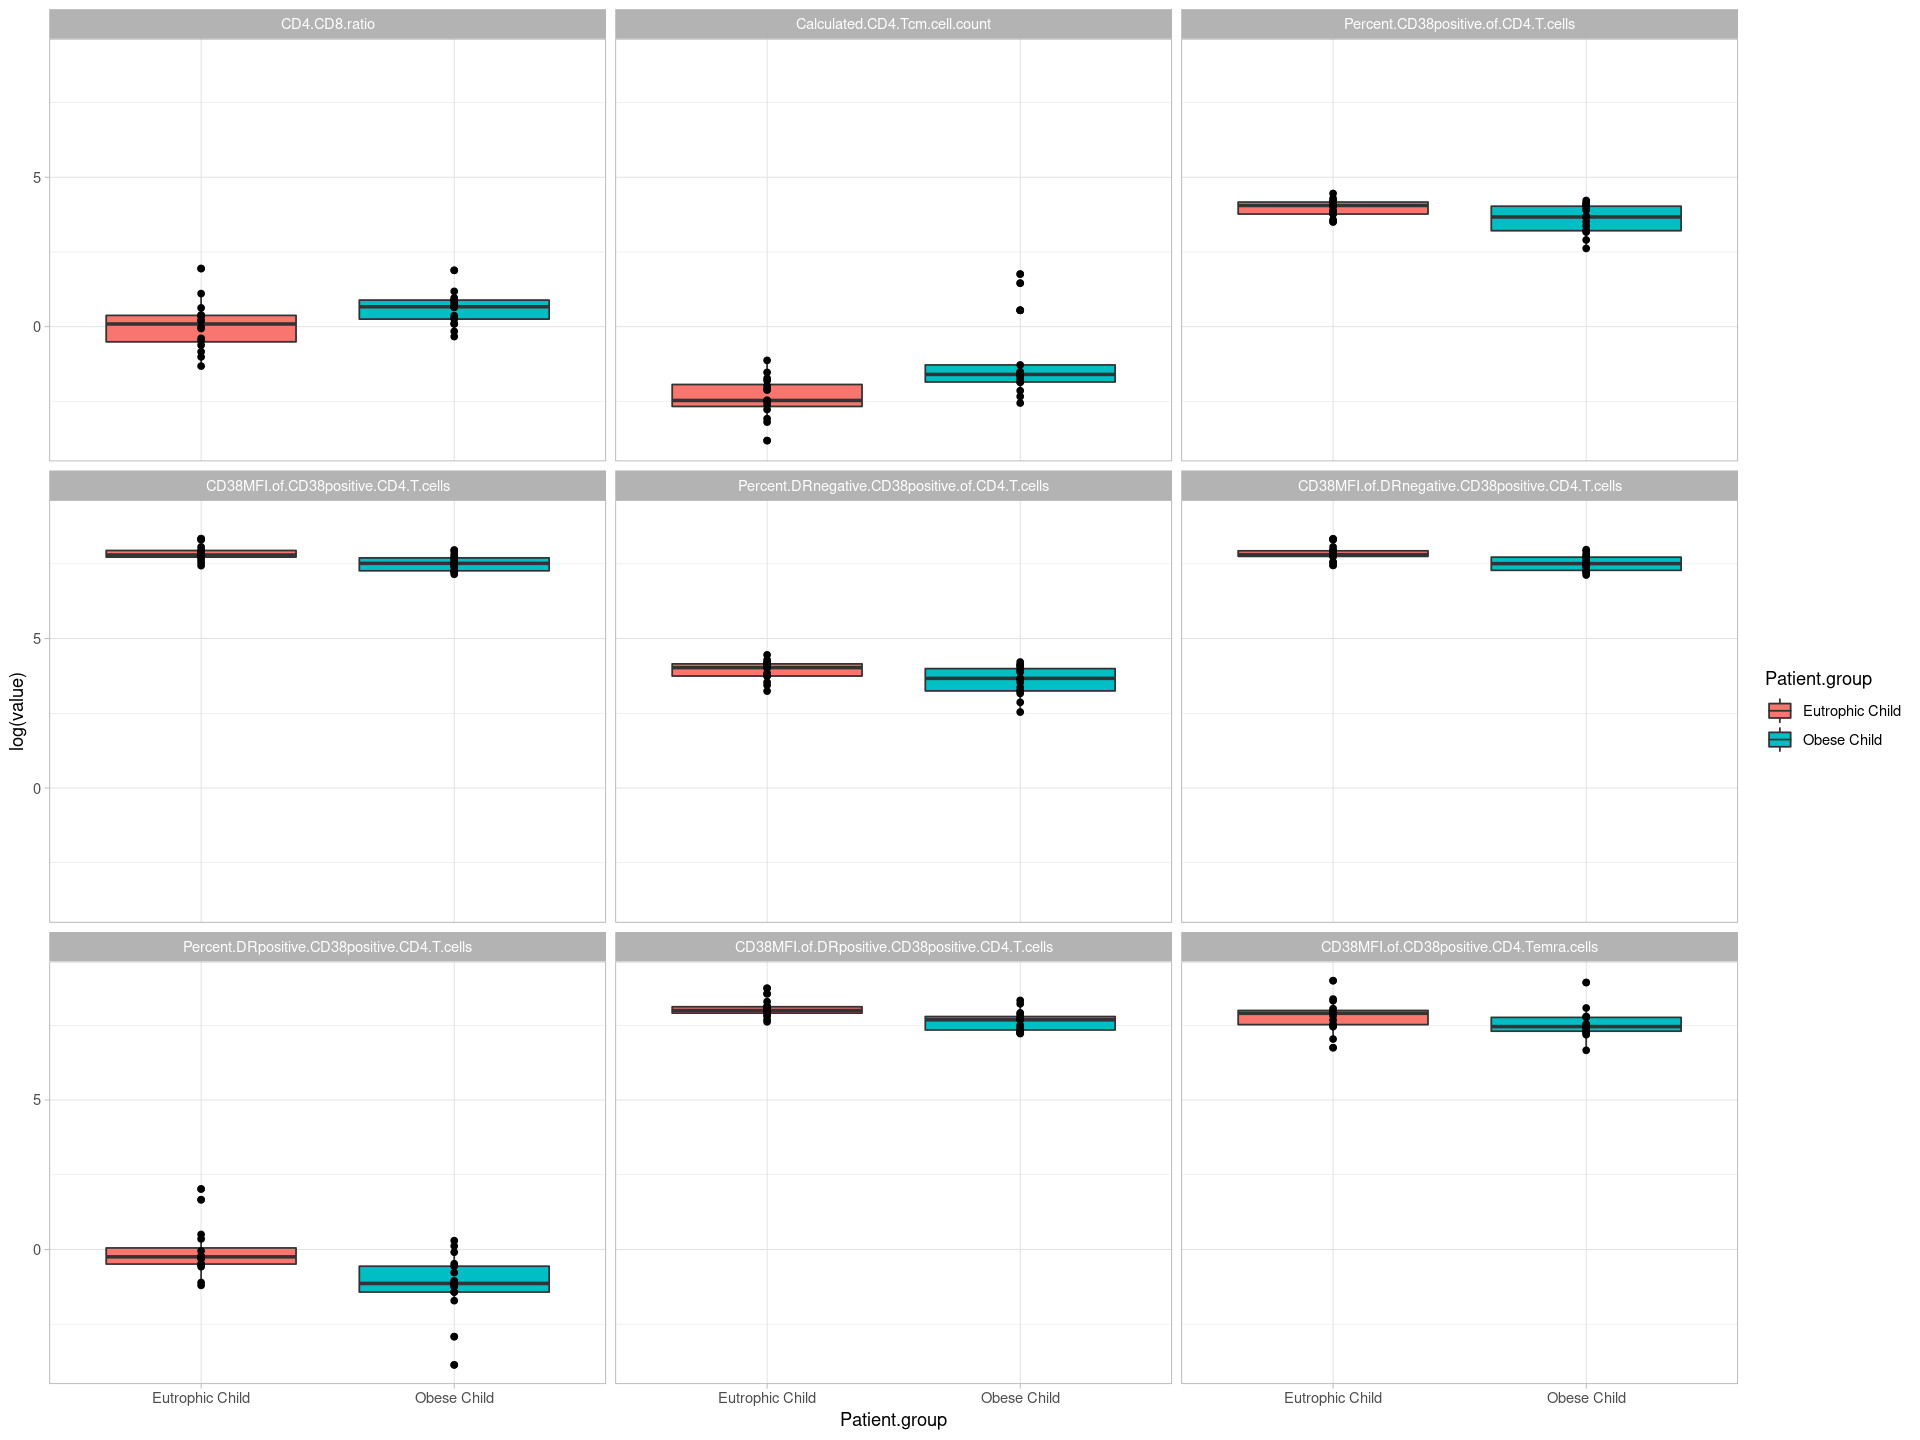

In [23]:
child_confident_vars <- wct_child_df %>% 
                     filter(p_val < 0.05) %>% 
                       dplyr::select(variable) %>% 
                         unlist

child[, colnames(child) %in% c('Patient.group', child_confident_vars[1:9])] %>% 
          melt %>% ggplot(aes(x=Patient.group, y=log(value))) +
             geom_boxplot(aes(fill=Patient.group)) + 
             geom_point() +
             facet_wrap(~variable, ncol = 3) +
             theme_light() 

## Prepare data for plotting

In [51]:
# Get the variance

joined.p = child.p %>% bind_rows(adult.p)

vars.p = joined.p %>% summarise_each(funs(var))
vars.p = vars.p %>% tidyr::gather("variable")

colnames(vars.p)[2] = "var"

In [52]:
# Merge child and adults wilcox
wct_df = wct_child_df %>% left_join(wct_adult_df, by='variable', suffix = c('.child', '.adult'))

# # Get the variance
wct_df = wct_df %>% left_join(vars.p)

colnames(wct_df)


Joining, by = "variable"



[1] "variable"    "p_val.child" "p_val.adult" "var"

## Plot wilcox resutls

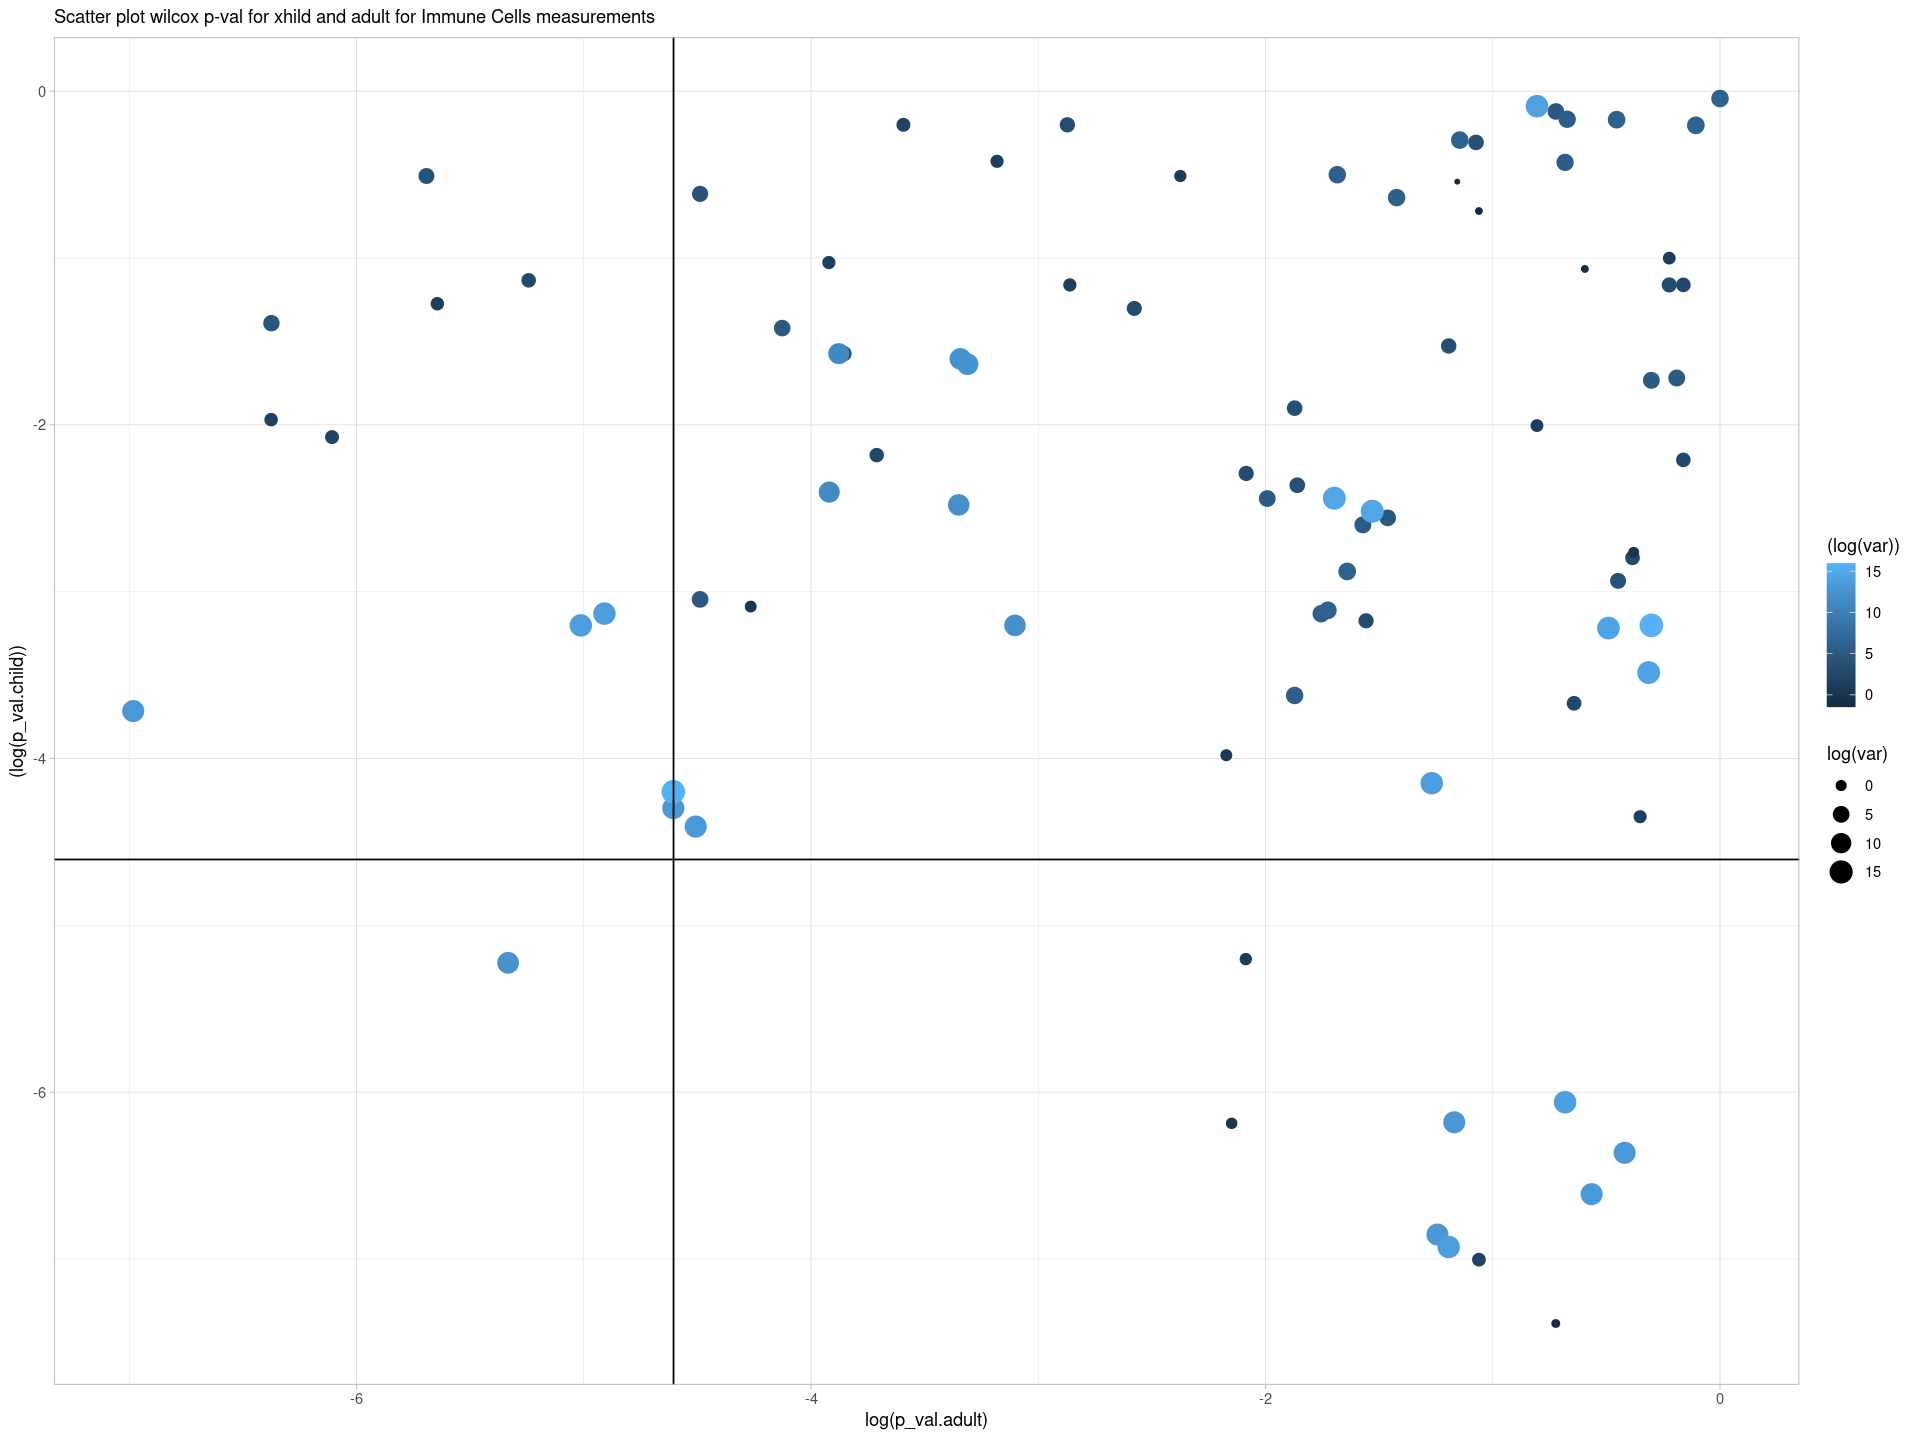

In [69]:
wct_df %>% ggplot(aes(x=log(p_val.adult), y=(log(p_val.child)), color=(log(var)))) +
    geom_point(aes(size = log(var))) + 
    geom_hline(yintercept = log(0.01)) +
    geom_vline(xintercept = log(0.01)) +
    labs(subtitle="Scatter plot wilcox p-val for xhild and adult for Immune Cells measurements") +
    theme_light()